Количество изображений:
train: 5372
val: 671
test: 672

Распределение классов (bbox):
bacterial_leaf_blight: 3217
brown_spot: 13992
leaf_mold: 6988


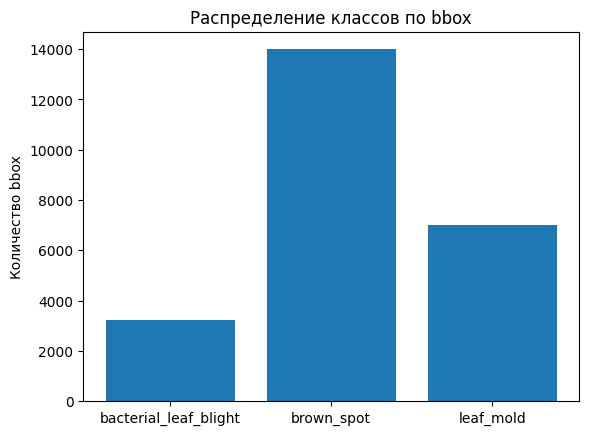

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

dataset_dir = 'data'
splits = ['train', 'val', 'test']
class_names = ['bacterial_leaf_blight', 'brown_spot', 'leaf_mold']

img_counts = {}
class_counts = Counter()

for split in splits:
    split_images_dir = os.path.join(dataset_dir, 'images', split)
    split_labels_dir = os.path.join(dataset_dir, 'labels', split)
    if not os.path.exists(split_images_dir):
        print(f"Папка {split_images_dir} не найдена!")
        continue
    if not os.path.exists(split_labels_dir):
        print(f"Папка {split_labels_dir} не найдена!")
        continue

    img_files = [f for f in os.listdir(split_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    img_counts[split] = len(img_files)
    for label_file in os.listdir(split_labels_dir):
        with open(os.path.join(split_labels_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

print("Количество изображений:")
for split in splits:
    print(f"{split}: {img_counts.get(split, 0)}")

print("\nРаспределение классов (bbox):")
for i, name in enumerate(class_names):
    print(f"{name}: {class_counts[i]}")

plt.bar(class_names, [class_counts[i] for i in range(3)])
plt.title('Распределение классов по bbox')
plt.ylabel('Количество bbox')
plt.show()

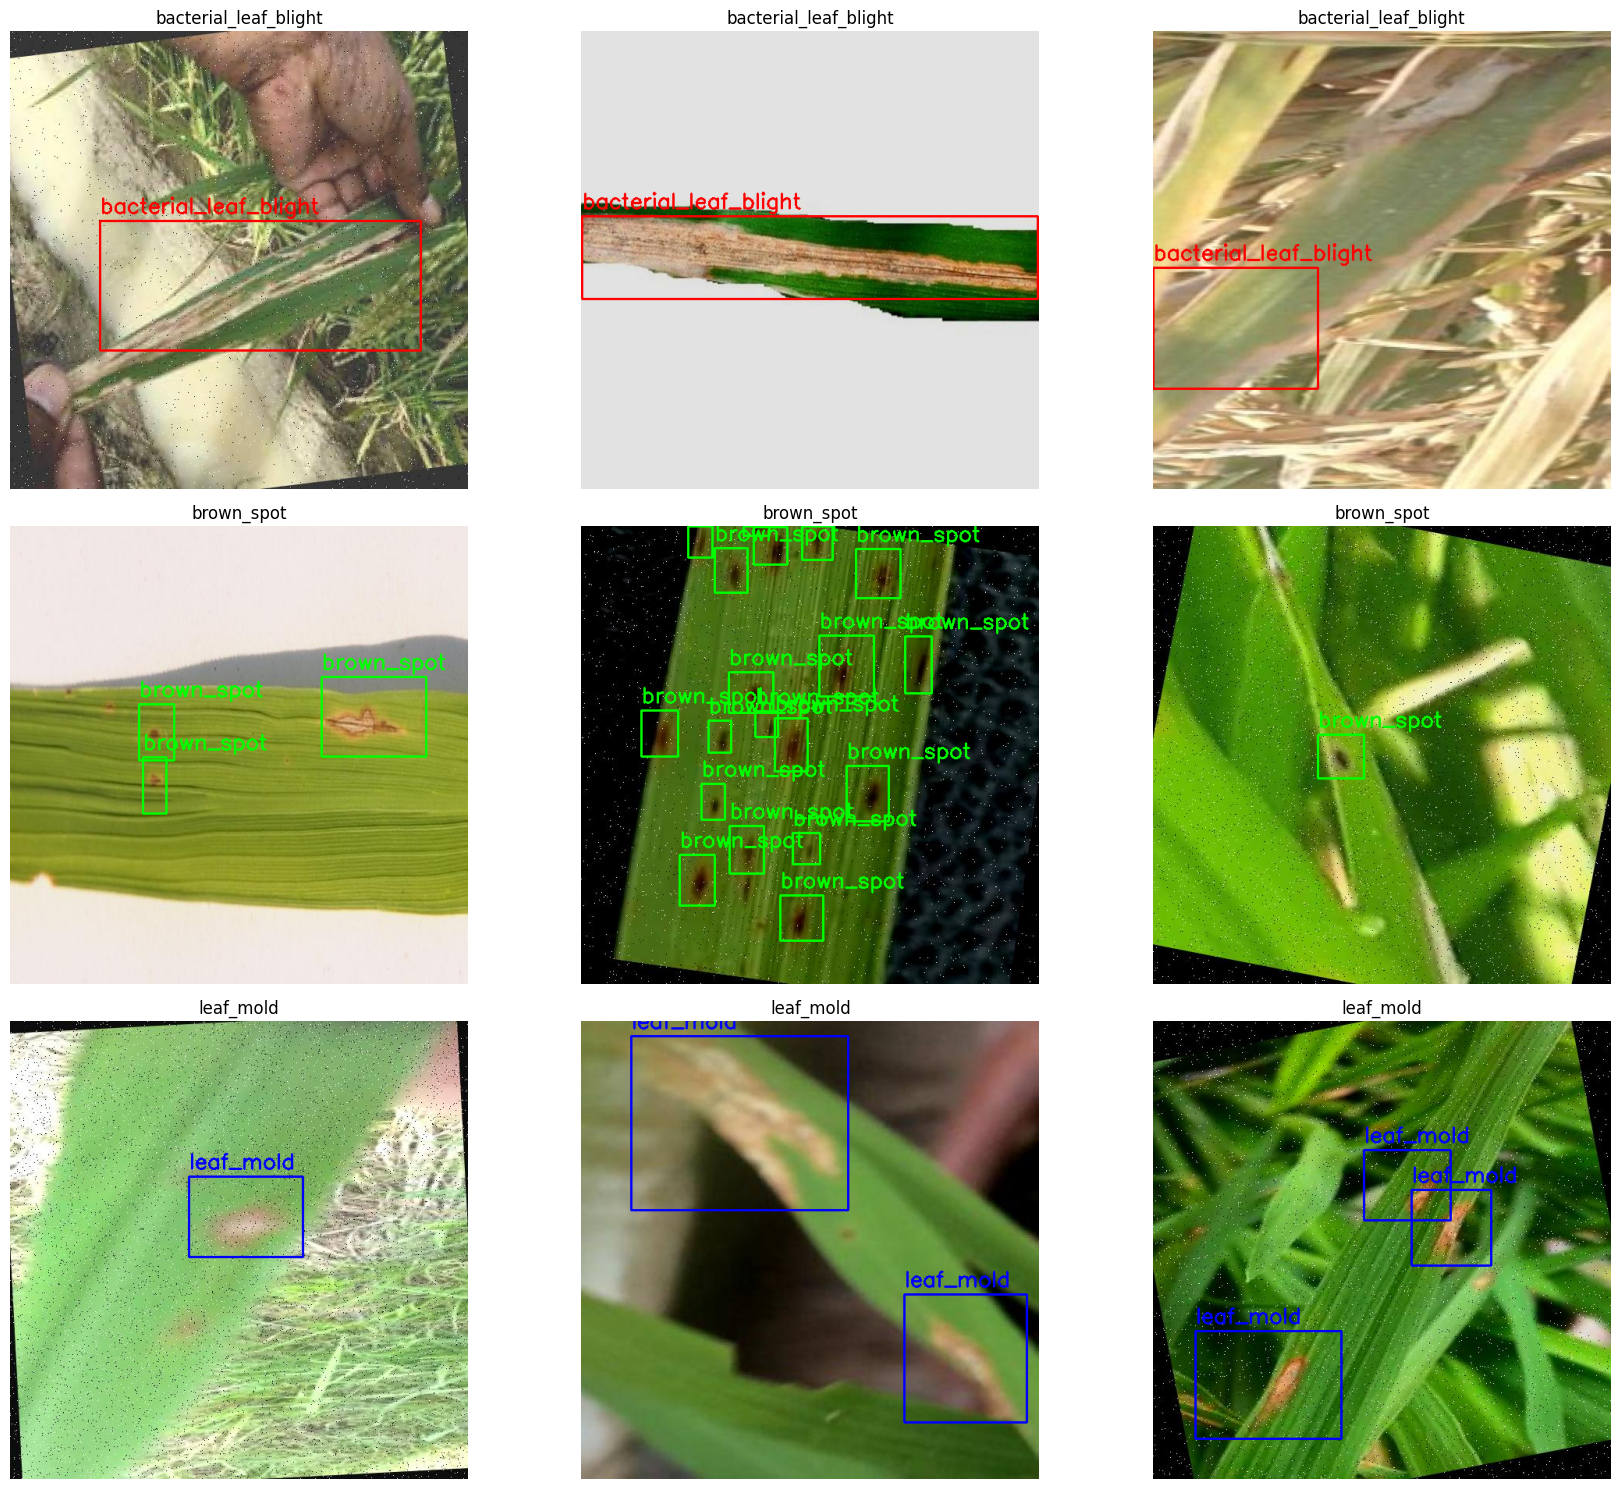

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

dataset_dir = 'data'
splits = ['train', 'val', 'test']
class_names = ['bacterial_leaf_blight', 'brown_spot', 'leaf_mold']
colors = [(255,0,0), (0,255,0), (0,0,255)]

def get_random_images_by_class(split, class_id, num_images=2):
    images_dir = os.path.join(dataset_dir, 'images', split)
    labels_dir = os.path.join(dataset_dir, 'labels', split)
    candidates = []
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            for line in f:
                if int(line.split()[0]) == class_id:
                    img_name = os.path.splitext(label_file)[0]
                    for ext in ['.jpg', '.jpeg', '.png']:
                        img_path = os.path.join(images_dir, img_name + ext)
                        if os.path.exists(img_path):
                            candidates.append((img_path, label_path))
                            break
                    break
    if len(candidates) >= num_images:
        return random.sample(candidates, num_images)
    else:
        return candidates
    
num_images_per_class = 3
fig, axs = plt.subplots(len(class_names), num_images_per_class, figsize=(6*num_images_per_class, 5*len(class_names)))

for class_id in range(len(class_names)):
    samples = get_random_images_by_class('train', class_id, num_images=num_images_per_class)
    for i, (img_path, label_path) in enumerate(samples):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cid, xc, yc, bw, bh = map(float, parts)
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                color = colors[int(cid)]
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, class_names[int(cid)], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        ax = axs[class_id, i] if len(class_names) > 1 else axs[i]
        ax.imshow(img)
        ax.set_title(f"{class_names[class_id]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Установка необходимых библиотек
!pip install ultralytics
!pip install roboflow
!pip install matplotlib

import os
import shutil
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Проверка доступности GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [ ]:
dataset_path =  'data'

def check_dataset_structure(base_path):
    required_folders = ['images', 'labels']
    splits = ['train', 'val', 'test']
    
    for folder in required_folders:
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Папка {folder} не найдена в датасете")
            
        for split in splits:
            split_path = os.path.join(folder_path, split)
            if not os.path.exists(split_path):
                raise FileNotFoundError(f"Папка {split} не найдена в {folder}")
                
    print("Структура датасета корректна")

check_dataset_structure(dataset_path)

with open(os.path.join(dataset_path, 'data.yaml'), 'r') as f:
    data_config = yaml.safe_load(f)
    
print("\nКонфигурация датасета:")
print(f"Количество классов: {data_config['nc']}")
print(f"Имена классов: {data_config['names']}")
print(f"Пути к данным: train: {data_config['train']}, val: {data_config['val']}, test: {data_config['test']}")

Структура датасета корректна

Конфигурация датасета:
Количество классов: 3
Имена классов: ['Bacteria_Leaf_Blight', 'Brown_Spot', 'Leaf_smut']
Пути к данным: train: ../data/images/train, val: ../data/images/val, test: ../data/images/test


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from ultralytics import YOLO

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-10, 10), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def apply_augmentation(image, annotations):
    transformed = transform(image=image, bboxes=annotations["bboxes"], category_id=annotations["category_ids"])
    return transformed["image"], {"bboxes": transformed["bboxes"], "category_ids": transformed["category_ids"]}

model = YOLO('yolov8m.pt')

dataset_path = 'data'
dataset_yaml_file_path = os.path.join(dataset_path, 'data.yaml')

config = {
    'data': dataset_yaml_file_path,
    'epochs': 30,
    'batch': 16,
    'imgsz': 640,
    'device': '0' if torch.cuda.is_available() else 'cpu',
    'workers': 2,
    'optimizer': 'auto',
    'lr0': 0.01,
    'lrf': 0.01,
    'weight_decay': 0.0005,
    'seed': 42,
    'name': 'yolov8m_rice_disease',
    'exist_ok': True,
    'pretrained': True,
    'verbose': True
}

results = model.train(**config)

100%|██████████| 49.7M/49.7M [00:00<00:00, 198MB/s]


Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/plants3/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_rice_disease, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

100%|██████████| 755k/755k [00:00<00:00, 18.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.6±7.5 MB/s, size: 70.0 KB)


train: Scanning /kaggle/input/plants3/data/labels/train... 5372 images, 49 backgrounds, 0 corrupt: 100%|██████████| 5372/5372 [00:10<00:00, 529.70it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/plants3/data/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.3 ms, read: 12.4±7.3 MB/s, size: 43.6 KB)


val: Scanning /kaggle/input/plants3/data/labels/val... 671 images, 10 backgrounds, 0 corrupt: 100%|██████████| 671/671 [00:01<00:00, 550.73it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/plants3/data/labels is not writeable, cache not saved.
Plotting labels to runs/detect/yolov8m_rice_disease/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8m_rice_disease
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.77G      2.164      2.508      1.994        135        640: 100%|██████████| 336/336 [03:34<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]

                   all        671       2482      0.212      0.267      0.168     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.84G      2.145      2.227      1.989         47        640: 100%|██████████| 336/336 [03:31<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]

                   all        671       2482      0.252      0.344      0.228     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.84G      2.096      2.118      1.944         46        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]

                   all        671       2482      0.389      0.421      0.334      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       7.9G      2.049      2.039      1.896         98        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]

                   all        671       2482      0.443      0.433      0.392      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       7.9G      1.985      1.919      1.875         76        640: 100%|██████████| 336/336 [03:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]

                   all        671       2482      0.465      0.557      0.494      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.91G      1.942      1.811      1.827         56        640: 100%|██████████| 336/336 [03:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]

                   all        671       2482      0.541      0.547      0.554      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.97G       1.92      1.737      1.805         51        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]

                   all        671       2482      0.541      0.594      0.577      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.05G      1.889      1.705       1.77         39        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]

                   all        671       2482        0.6      0.579        0.6      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.04G      1.851      1.611      1.749         79        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]

                   all        671       2482      0.691      0.633      0.676      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.07G      1.815      1.528      1.722         63        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]

                   all        671       2482      0.627      0.655      0.677      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.07G      1.781      1.498        1.7         48        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]

                   all        671       2482       0.68      0.687      0.697      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.05G      1.759      1.422      1.682         85        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]

                   all        671       2482       0.77      0.738      0.789      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.07G      1.712      1.371      1.659         71        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]

                   all        671       2482      0.762       0.74      0.811      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.05G      1.682      1.305      1.624         53        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]

                   all        671       2482      0.772      0.782      0.829      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.05G      1.654      1.262      1.595         38        640: 100%|██████████| 336/336 [03:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]

                   all        671       2482      0.805      0.765      0.845      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.05G      1.602      1.209      1.577         58        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        671       2482      0.817      0.787      0.843      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.05G      1.581      1.179      1.555         78        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]

                   all        671       2482      0.846      0.801      0.876      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.05G      1.541      1.134      1.544         30        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]

                   all        671       2482      0.853      0.836      0.891      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.05G      1.496      1.072      1.504         87        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]

                   all        671       2482      0.853      0.855      0.913      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.05G      1.458      1.032      1.475        136        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        671       2482      0.887      0.844      0.915      0.548


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.07G      1.424     0.9059      1.518         42        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]

                   all        671       2482      0.891      0.882      0.927      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.08G      1.357     0.8397      1.478         39        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]

                   all        671       2482      0.896      0.881      0.936      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.07G      1.294      0.788      1.427         18        640: 100%|██████████| 336/336 [03:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]

                   all        671       2482      0.905      0.883      0.944      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.07G      1.261     0.7555      1.397         25        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]

                   all        671       2482      0.935      0.898      0.953      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.05G      1.213     0.7106      1.358         31        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]

                   all        671       2482      0.929        0.9      0.956      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.05G      1.173     0.6873      1.328         32        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]

                   all        671       2482      0.919       0.91      0.959      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.96G      1.133     0.6567      1.307         29        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]

                   all        671       2482      0.938      0.907      0.963      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.07G      1.094     0.6342      1.278         46        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        671       2482      0.935      0.911      0.964      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.05G      1.046     0.6117      1.239         48        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        671       2482      0.936      0.918      0.964      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.06G      1.016     0.5836      1.216         23        640: 100%|██████████| 336/336 [03:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        671       2482      0.949      0.918      0.968      0.731



30 epochs completed in 1.847 hours.
Optimizer stripped from runs/detect/yolov8m_rice_disease/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/yolov8m_rice_disease/weights/best.pt, 52.0MB

Validating runs/detect/yolov8m_rice_disease/weights/best.pt...
Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        671       2482      0.949      0.918      0.968      0.731
  Bacteria_Leaf_Blight        282        312      0.934      0.981      0.985      0.837
            Brown_Spot        172       1603      0.933      0.825      0.935      0.585
             Leaf_smut        207        567       0.98      0.947      0.982      0.771
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/yolov8m_rice_disease


Анализ результатов из: runs/detect/yolov8m_rice_disease/


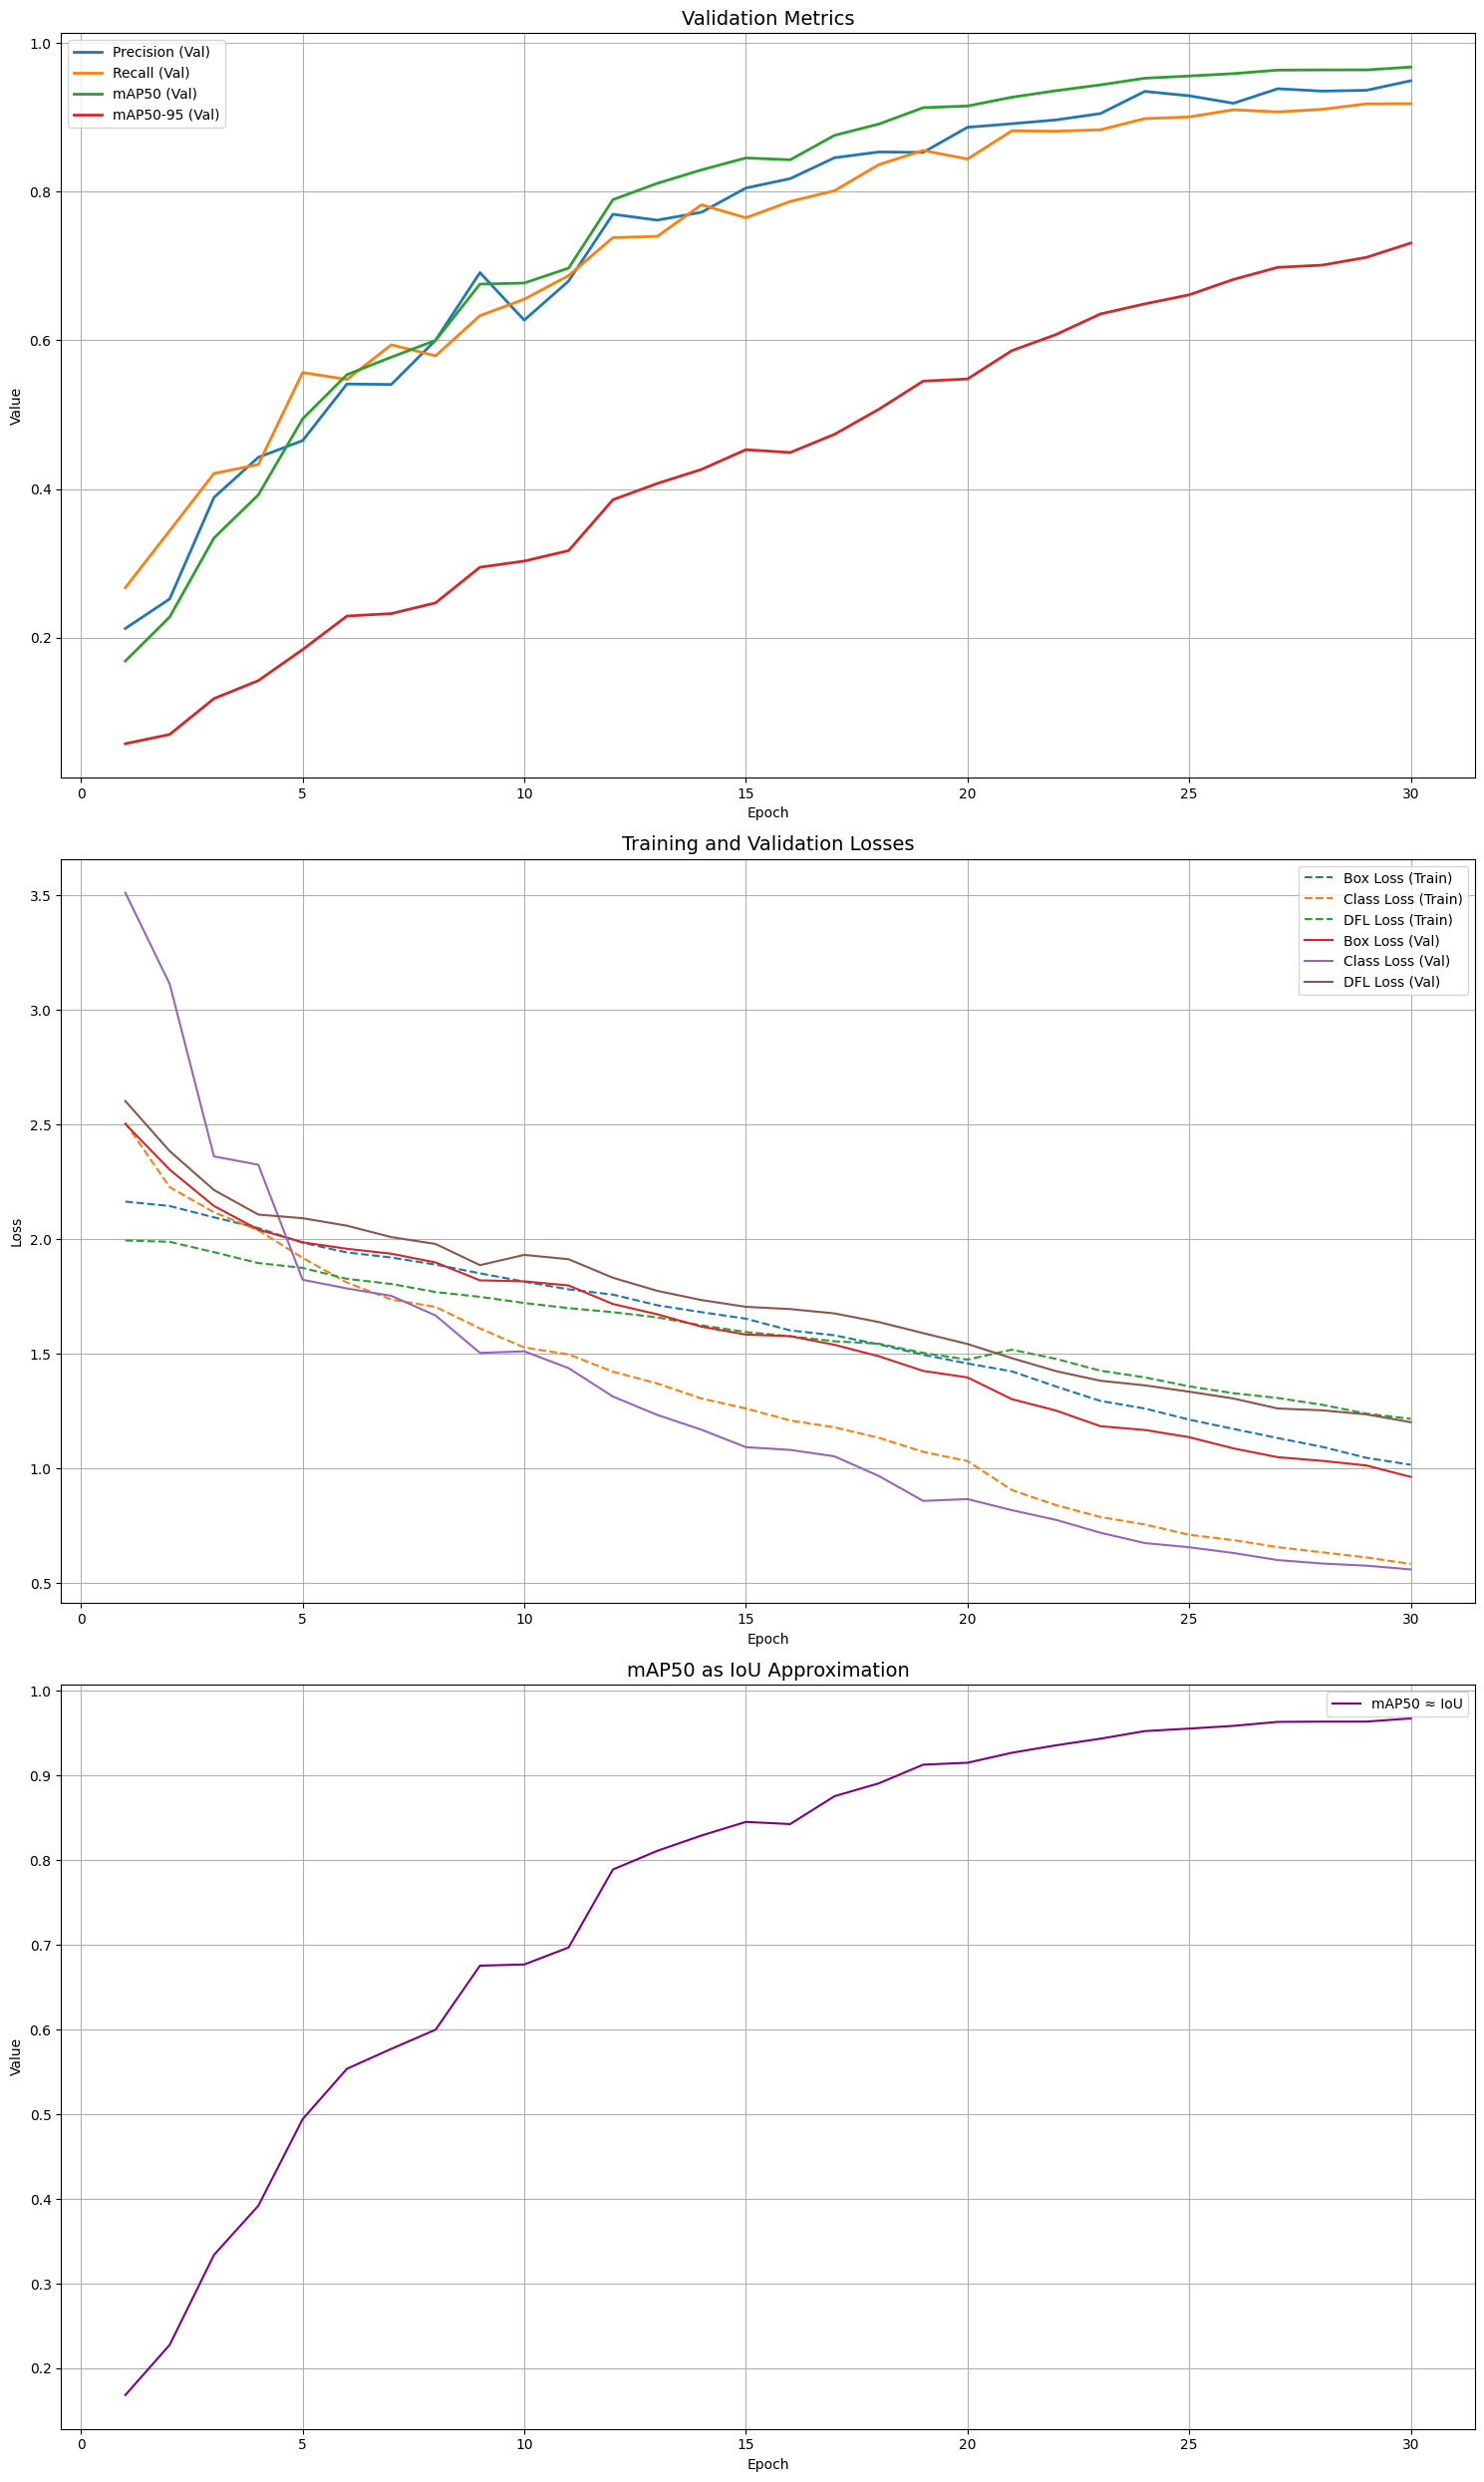


Примеры валидационных предсказаний:


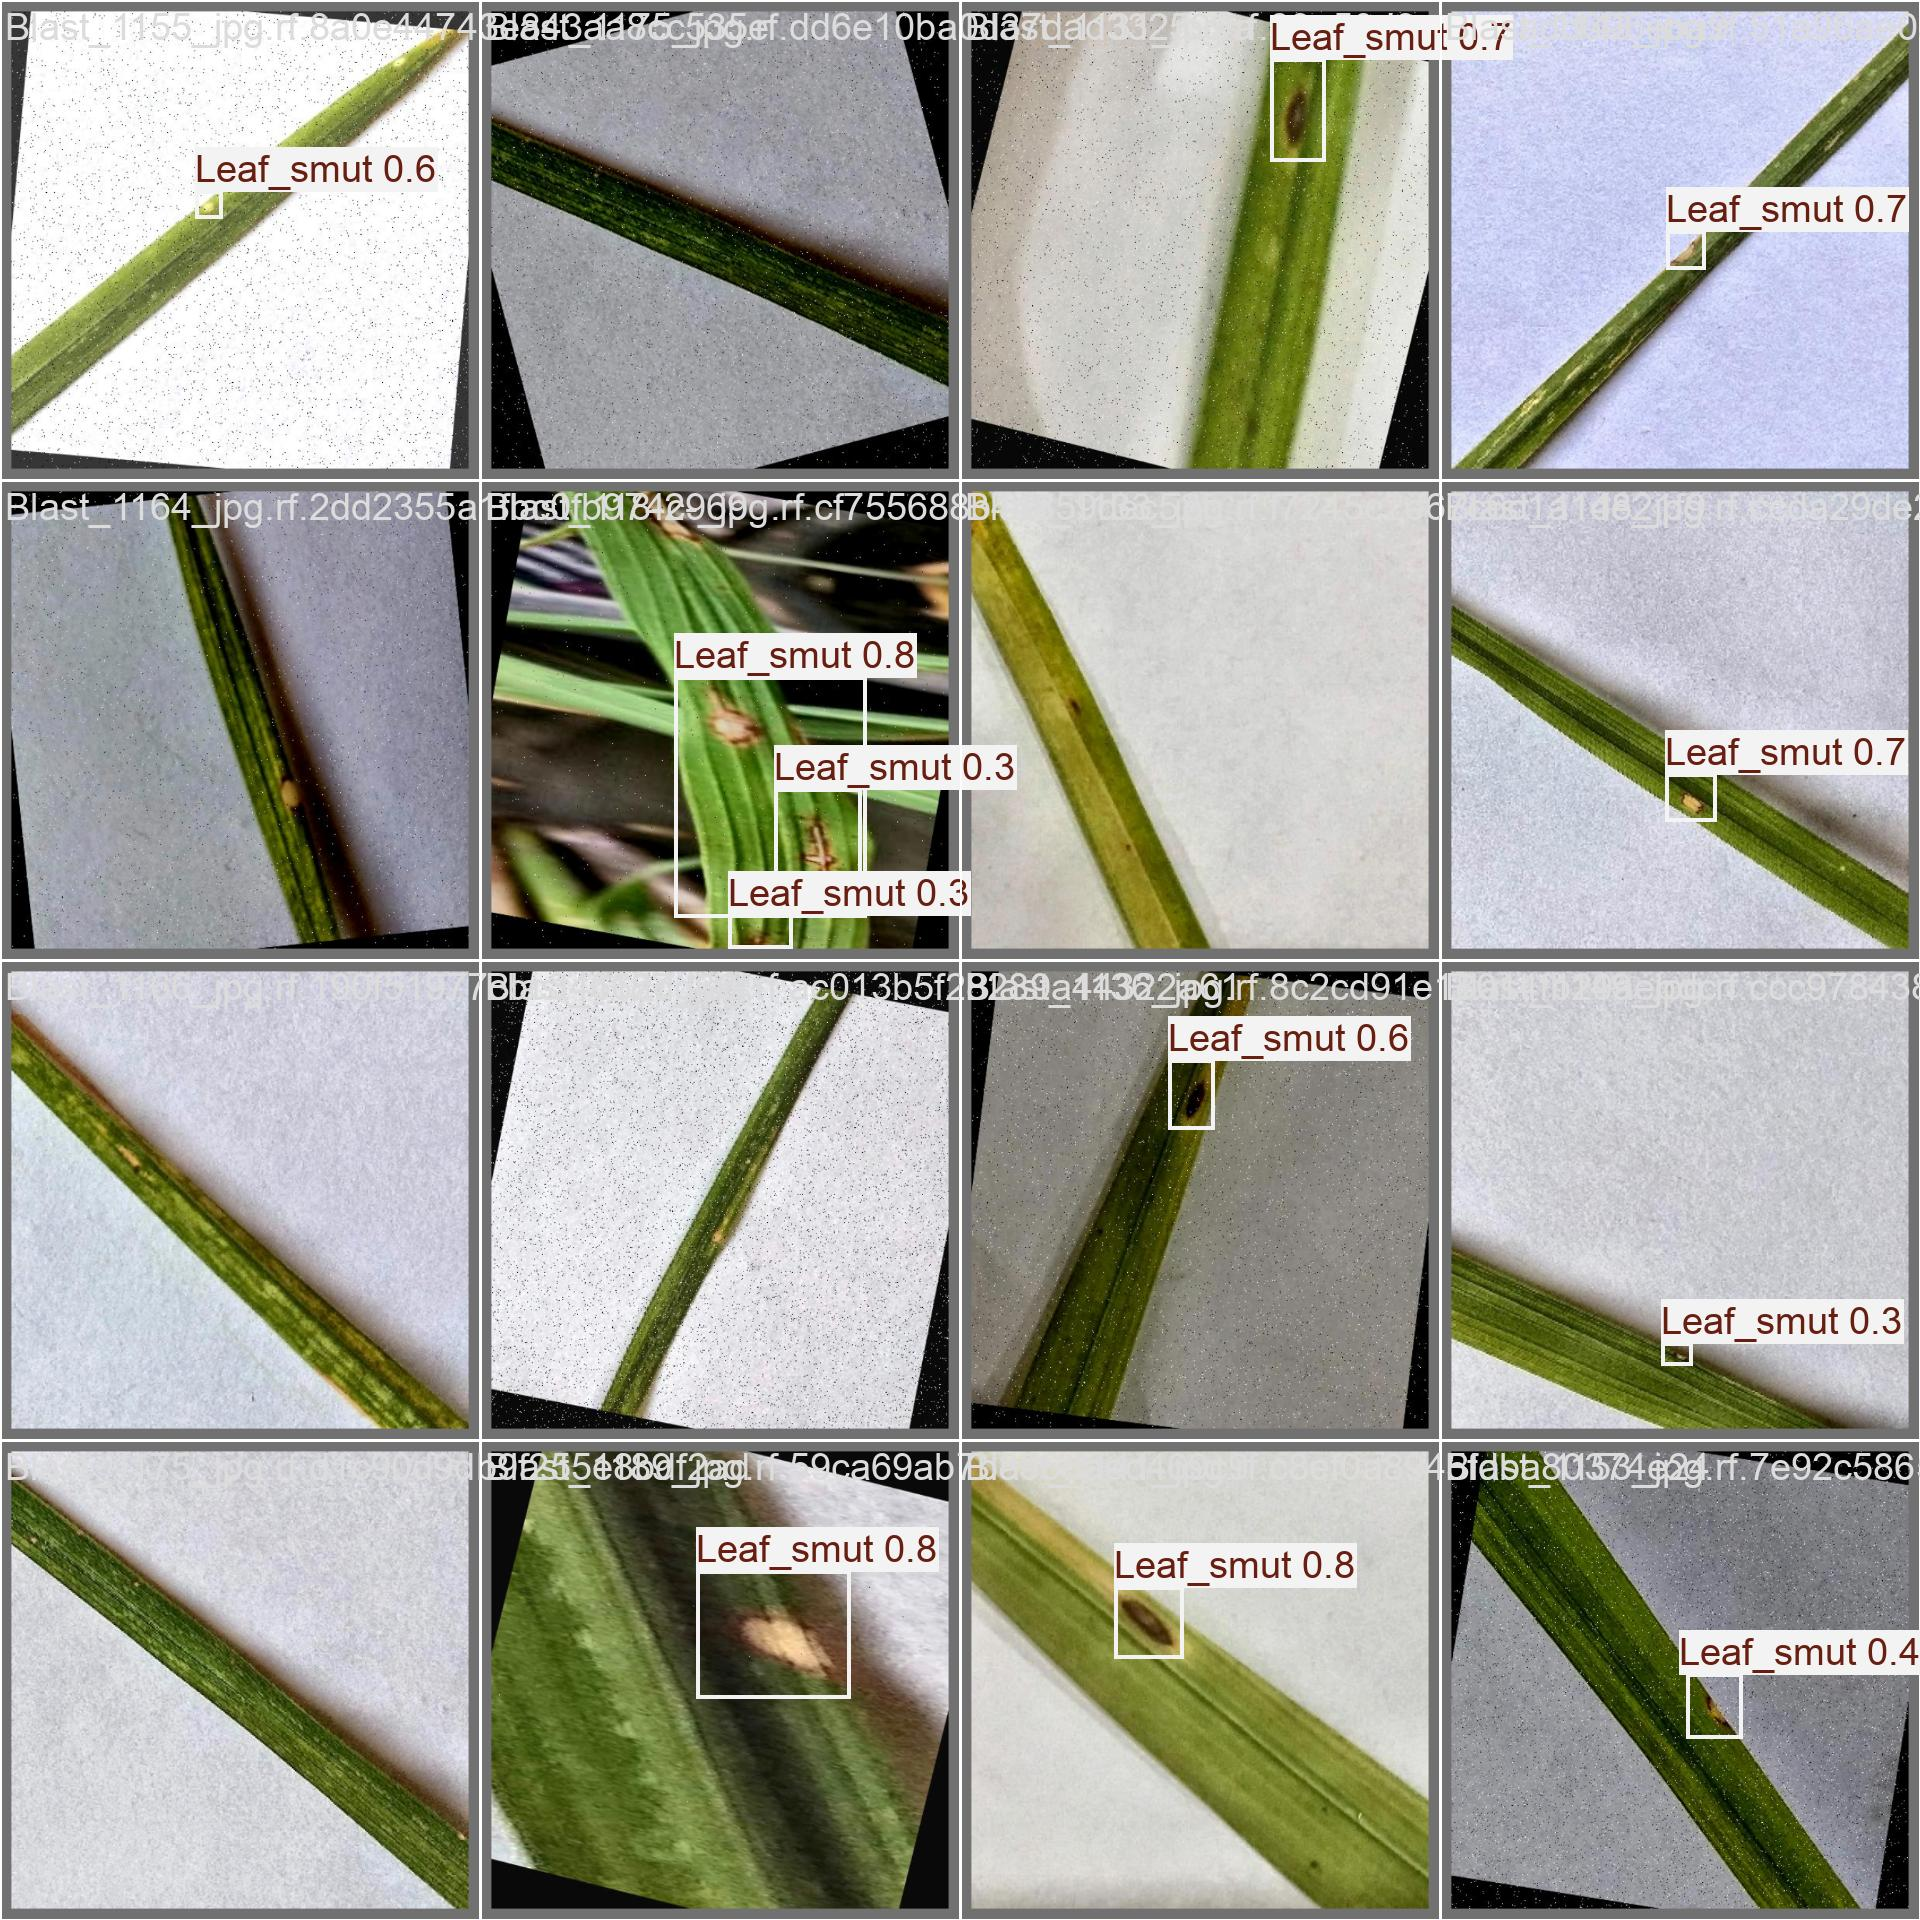

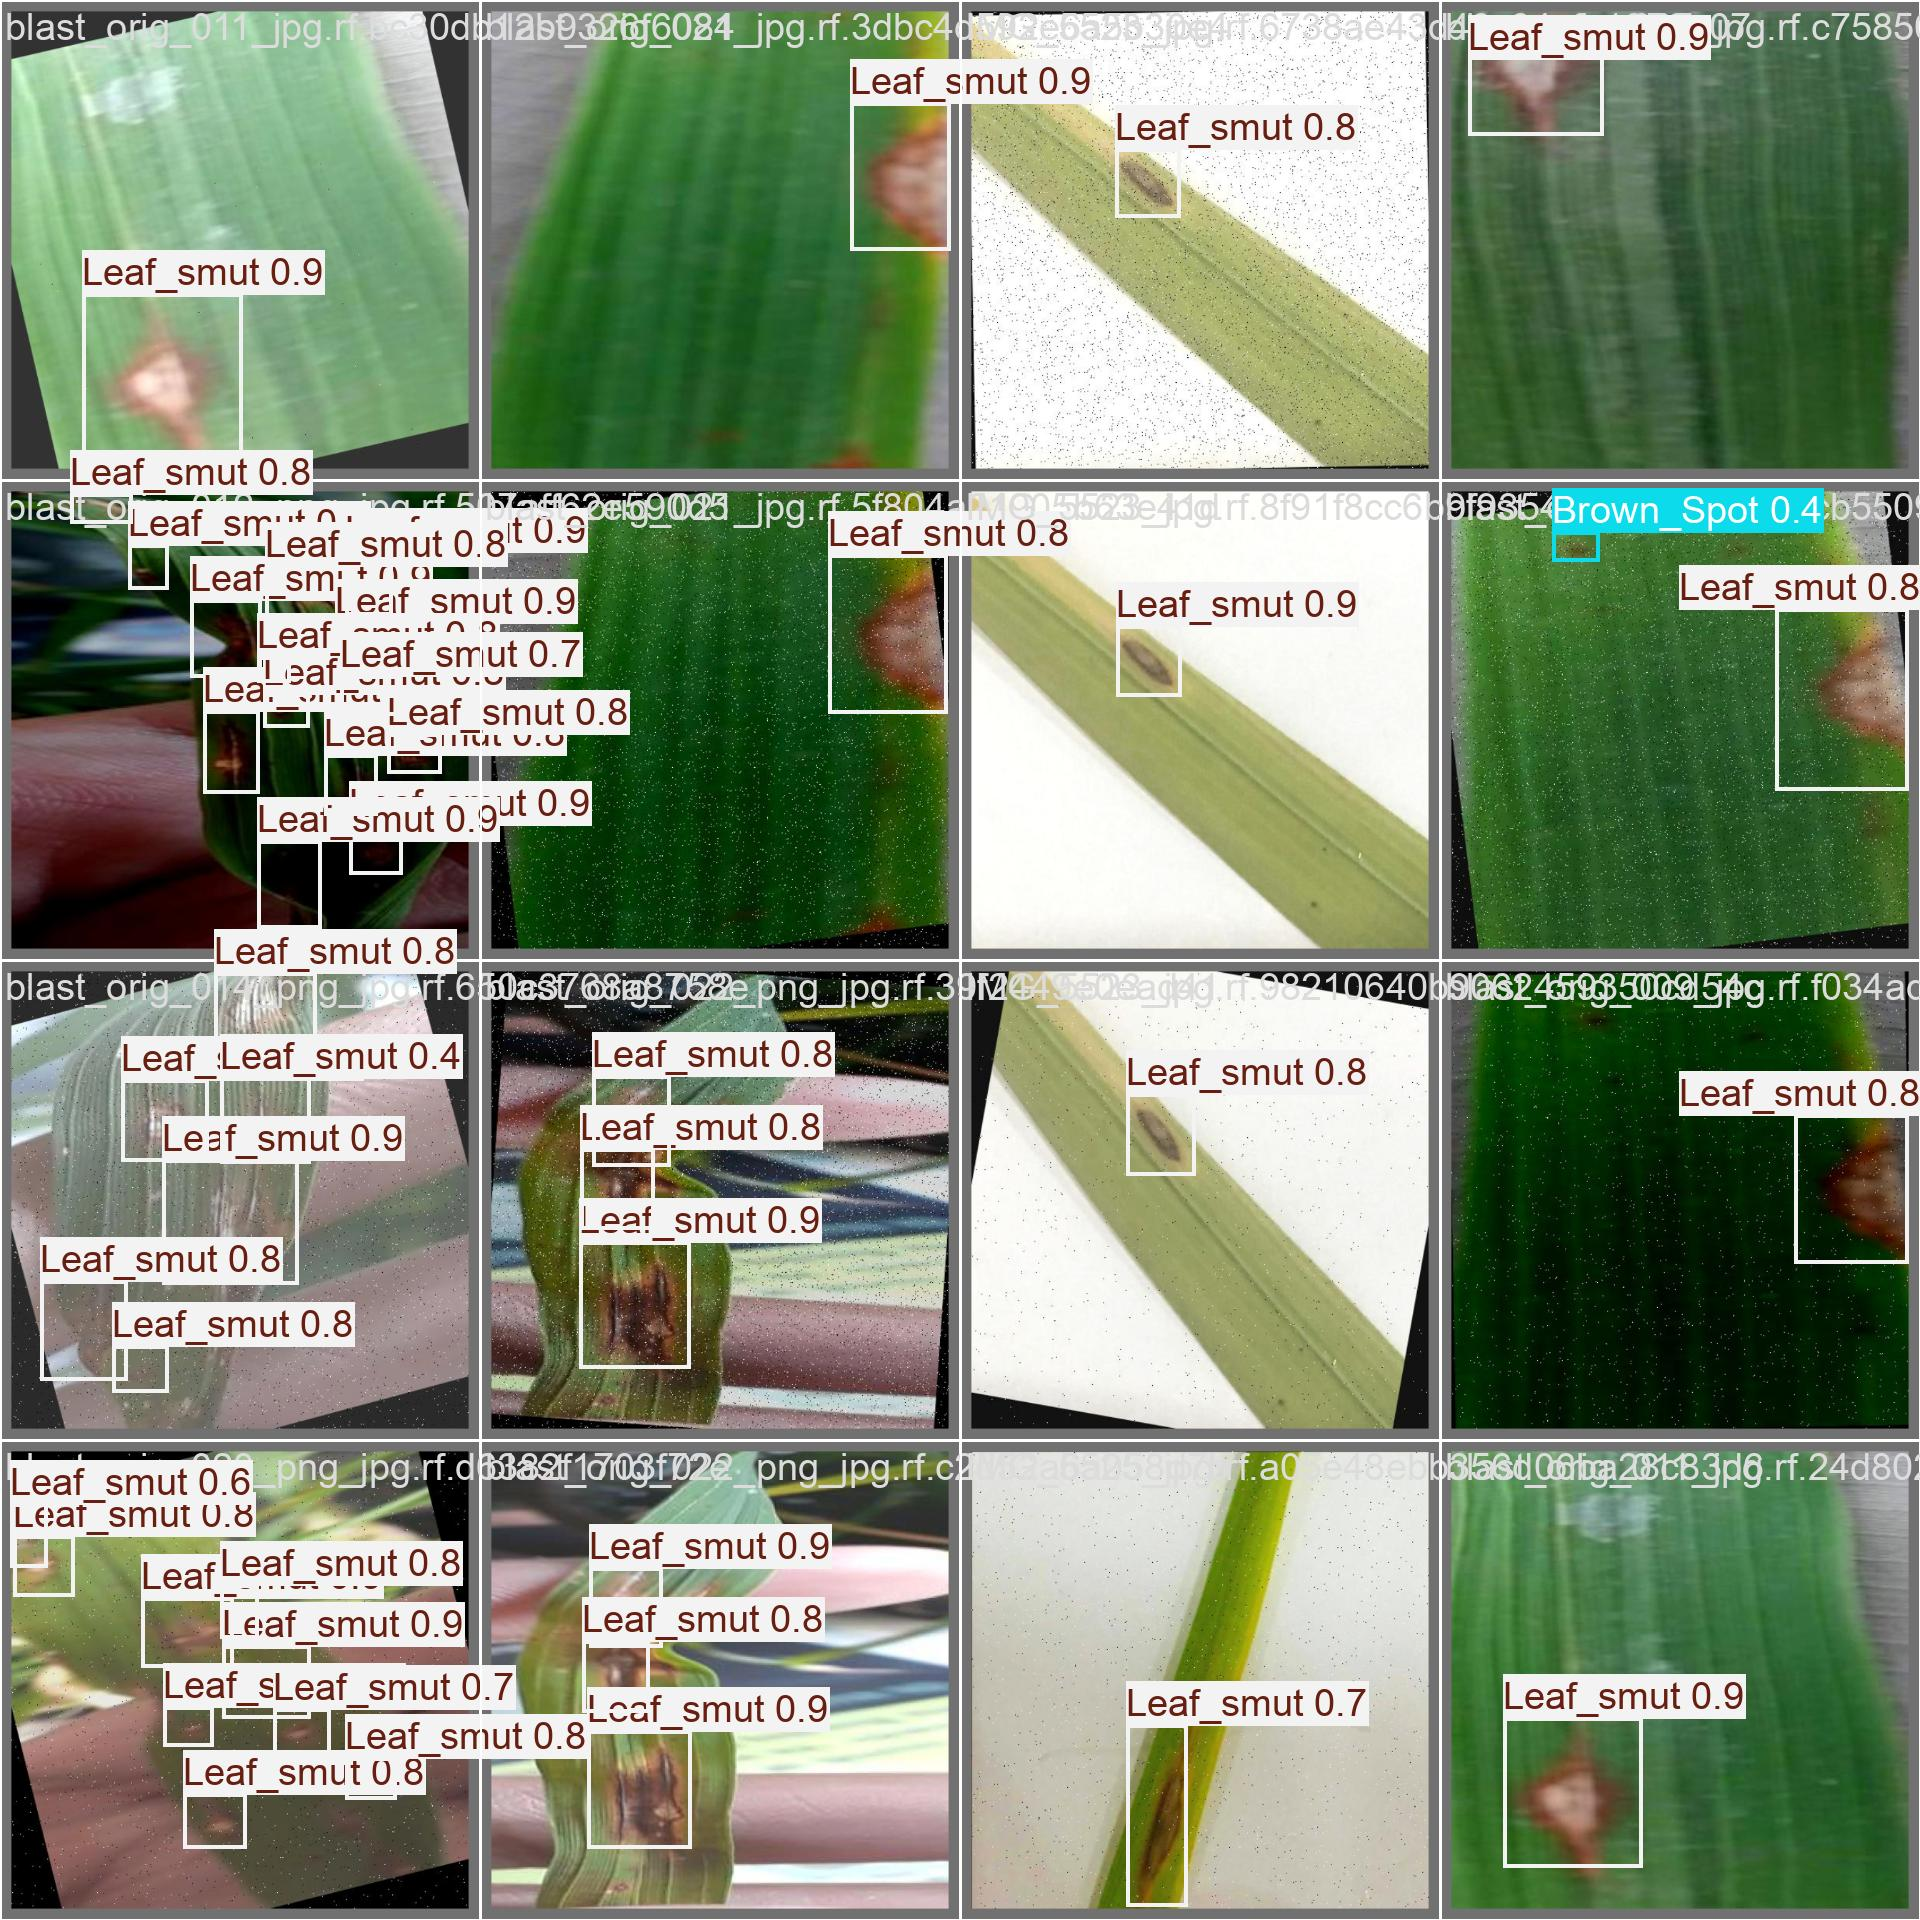

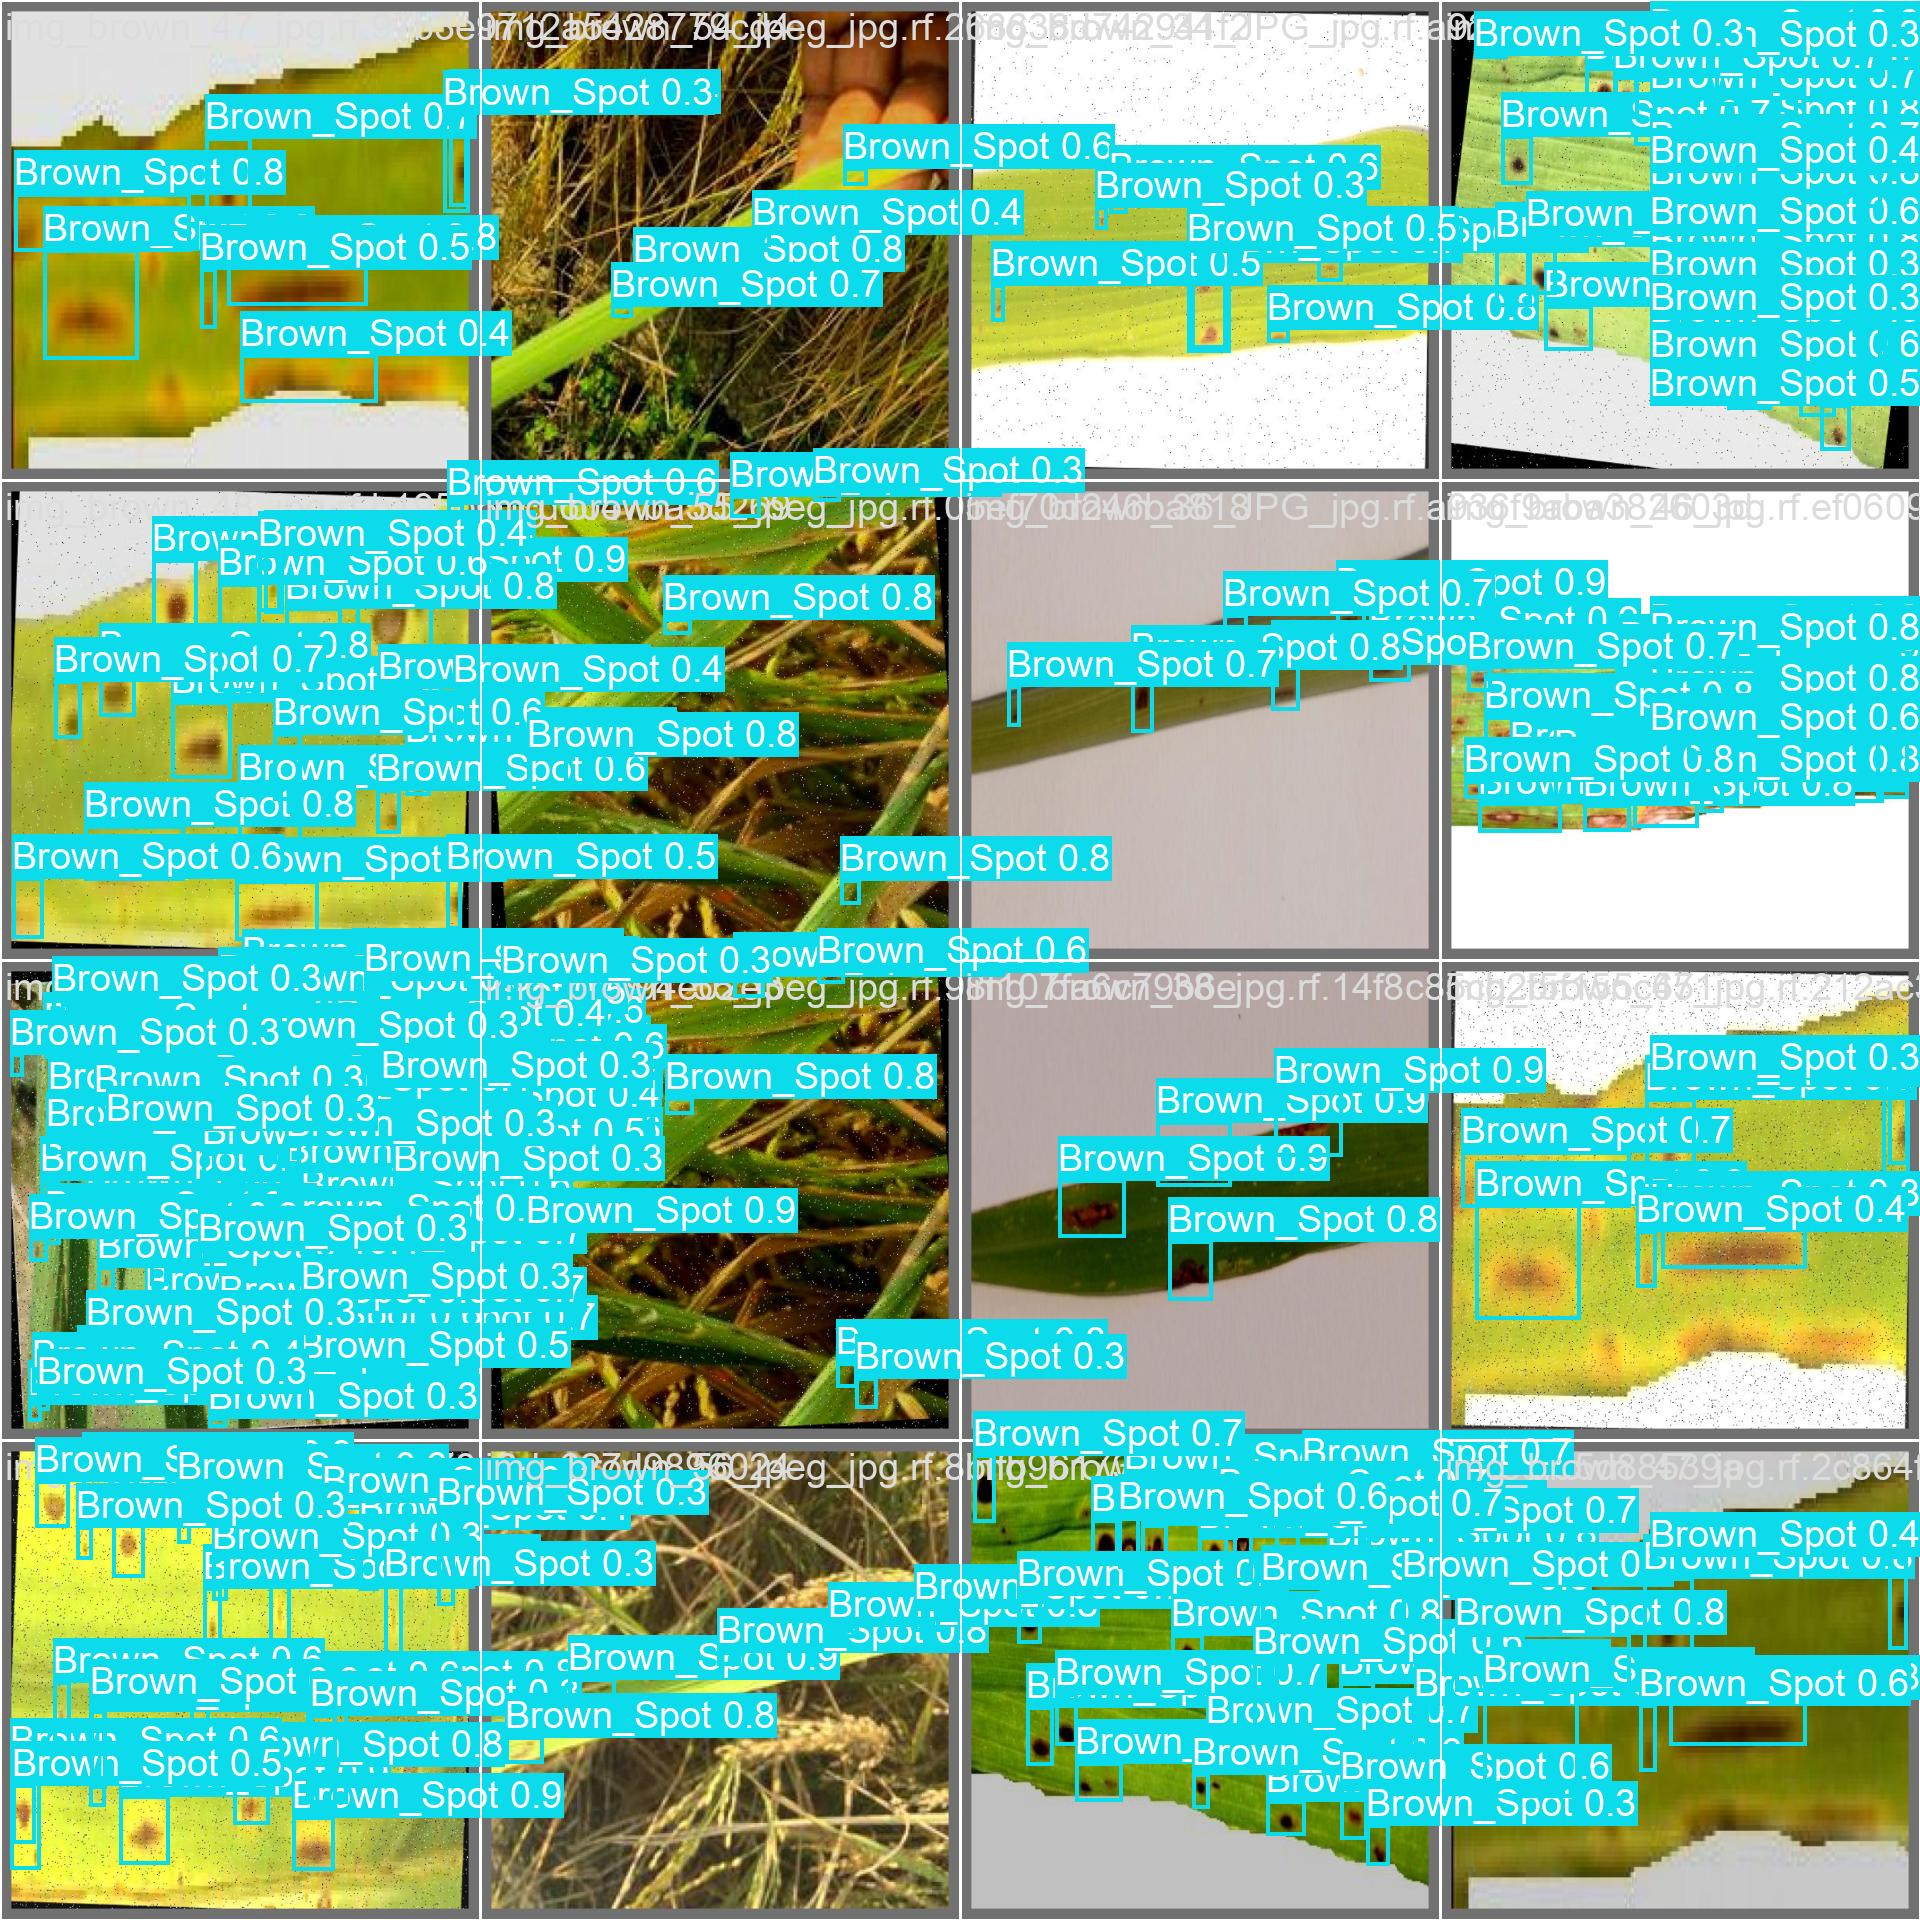


Лучшая эпоха: 29
Лучший mAP50: 0.968


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Image, display

def plot_training_results(results_dir):
    results_file = os.path.join(results_dir, 'results.csv')
    if not os.path.exists(results_file):
        raise FileNotFoundError(f"Файл с результатами не найден: {results_file}")
    
    df = pd.read_csv(results_file)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))
    val_metrics = {
        'metrics/precision(B)': 'Precision (Val)',
        'metrics/recall(B)': 'Recall (Val)', 
        'metrics/mAP50(B)': 'mAP50 (Val)',
        'metrics/mAP50-95(B)': 'mAP50-95 (Val)'
    }
    
    for metric, label in val_metrics.items():
        if metric in df.columns:
            ax1.plot(df['epoch'], df[metric], label=label, linewidth=2)
    
    ax1.set_title('Validation Metrics', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)
    
    train_losses = {
        'train/box_loss': 'Box Loss (Train)',
        'train/cls_loss': 'Class Loss (Train)',
        'train/dfl_loss': 'DFL Loss (Train)'
    }
    
    val_losses = {
        'val/box_loss': 'Box Loss (Val)',
        'val/cls_loss': 'Class Loss (Val)',
        'val/dfl_loss': 'DFL Loss (Val)'
    }
    
    for loss, label in train_losses.items():
        if loss in df.columns:
            ax2.plot(df['epoch'], df[loss], label=label, linestyle='--')
    
    for loss, label in val_losses.items():
        if loss in df.columns:
            ax2.plot(df['epoch'], df[loss], label=label, linestyle='-')
    
    ax2.set_title('Training and Validation Losses', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    if 'metrics/IoU' in df.columns:
        ax3.plot(df['epoch'], df['metrics/IoU'], label='IoU (Val)', color='purple')
        ax3.set_title('Intersection over Union (IoU)', fontsize=14)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('IoU')
        ax3.legend()
        ax3.grid(True)
    else:
        if 'metrics/mAP50(B)' in df.columns:
            ax3.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50 ≈ IoU', color='purple')
            ax3.set_title('mAP50 as IoU Approximation', fontsize=14)
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Value')
            ax3.legend()
            ax3.grid(True)

    plt.tight_layout()
    plt.show()    
    return df

def find_latest_run():
    runs_dir = os.path.join('runs', 'detect')
    all_runs = sorted(glob(os.path.join(runs_dir, '*/')), key=os.path.getmtime)
    return all_runs[-1] if all_runs else None

latest_run = find_latest_run()
if latest_run:
    print(f"Анализ результатов из: {latest_run}")
    try:
        results_df = plot_training_results(latest_run)
        val_images = glob(os.path.join(latest_run, 'val_batch*pred.jpg'))[:3]
        if val_images:
            print("\nПримеры валидационных предсказаний:")
            cols = st.columns(len(val_images)) if 'streamlit' in globals() else None
            for i, img_path in enumerate(val_images):
                if cols:
                    with cols[i]:
                        st.image(img_path, caption=f"Пример {i+1}", use_column_width=True)
                else:
                    display(Image(filename=img_path, width=600))
        else:
            print("Валидационные примеры не найдены")
        if not results_df.empty:
            best_epoch = results_df['metrics/mAP50(B)'].idxmax()
            print(f"\nЛучшая эпоха: {best_epoch}")
            print(f"Лучший mAP50: {results_df['metrics/mAP50(B)'].max():.3f}")
            if 'metrics/IoU' in results_df.columns:
                print(f"Лучший IoU: {results_df['metrics/IoU'].max():.3f}")
    except Exception as e:
        print(f"Ошибка при анализе результатов: {str(e)}")
else:
    print("Директория с результатами не найдена")